# Import Libraries


In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from keras.models import Model
import random as rn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.cm as cm
import cv2
from google.colab.patches import cv2_imshow

# Load dataset from Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run '/content/drive/Shareddrives/CIDL Project/Macrì,Tortora/Utilities.ipynb'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [ ]:
!unzip -q "/content/drive/Shareddrives/CIDL Project/data/split.zip" -d "/content"

In [ ]:
# First image of the test set
img_path = '/content/split/test/AK/ISIC_0066082.jpg'

In [ ]:
GLOBAL_MODELS_FOLDER = "/content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models"

# Utility functions

In [ ]:
def get_index_by_layer_name(model, layer_name):

  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
def display_feature_maps(layer_names, activations, how_many_layers_to_show=None, how_many_layers_to_skip=0):

  layer_names = layer_names[how_many_layers_to_skip:]
  activations = activations[how_many_layers_to_skip:]

  count_layers = 0
  for layer_name, layer_activation in zip(layer_names, activations):

      count_layers += 1
      if how_many_layers_to_show: # not None
        if count_layers > how_many_layers_to_show:
          break

      # Number of features in the feature map
      n_features = layer_activation.shape[-1]

      # The feature map has shape (1, image_height, image_width, n_features)
      # but image_height = image_width
      size = layer_activation.shape[1]

      n_cols = n_features // images_per_row
      display_grid = np.zeros((size * n_cols, images_per_row * size))

      for col in range(n_cols):
          for row in range(images_per_row):
              channel_image = layer_activation[0,:, :, col * images_per_row + row]
              channel_image -= channel_image.mean() # remove the mean
              channel_image /= channel_image.std() # divide by the standard deviation
              # now we have a standard normal distribution with the 95% of the pixel values in the interval [-2,2] 
              # we must multiply for 64 to get the interval [-128, 128]
              channel_image *= 64 
              # now we can sum 128 to get the interval [0, 255]
              channel_image += 128
              channel_image = np.clip(channel_image, 0, 255).astype('uint8')
              display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

      # Display the grid
      scale = 1. / size
      plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='gray')
      
  plt.show()

# Layers activation


In [ ]:
# preprocess the image into a 4D tensor

img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis=0)

# Its shape is (1, 180, 180, 1)
print(img_tensor.shape)

(1, 224, 224, 3)


In [ ]:
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

## CNN from scratch
We will first analyze the best CNN from scratch that we have found.

In [ ]:
# We preprocess the image into a 4D tensor (3D image + 1 batch dimension)
image_height = 300
image_width = 300
img = image.load_img(img_path, target_size=(image_height, image_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # add batch dimension

# Its shape is (1, image_height, image_width, 3)
print(img_tensor.shape)

(1, 300, 300, 3)


In [ ]:
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [ ]:
model = load_model(GLOBAL_MODELS_FOLDER + '/CNN_From_Scratch/experiment_3.h5')
model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                  

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) # one input and multiple outputs

conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7


In [ ]:
activations = activation_model.predict(img_tensor)
for out in activations:
  print(out.shape)

(1, 298, 298, 32)
(1, 149, 149, 32)
(1, 147, 147, 64)
(1, 73, 73, 64)
(1, 71, 71, 128)
(1, 23, 23, 128)
(1, 21, 21, 256)
(1, 7, 7, 256)


Let's display our feature maps

In [ ]:
images_per_row = 16

In [ ]:
display_feature_maps(layer_names, activations)

## ResNet101
Now we analyze the best models found with Resnet101.

In [ ]:
# We preprocess the image into a 4D tensor (3D image + 1 batch dimension)
image_height = 300
image_width = 300
img = image.load_img(img_path, target_size=(image_height, image_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # add batch dimension

# Its shape is (1, image_height, image_width, 3)
print(img_tensor.shape)

(1, 300, 300, 3)


In [ ]:
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/ResNet101/ResNet101_finetuning1_1.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet101_no_last_2_blocks   (None, 7, 7, 2048)       33714560  
 (Functional)                                                    
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
model = model.get_layer('resnet101_no_last_2_blocks')

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) # one input and multiple outputs

conv1_conv
pool1_pool
conv2_block1_1_conv
conv2_block1_2_conv
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block2_1_conv
conv2_block2_2_conv
conv2_block2_3_conv
conv2_block3_1_conv
conv2_block3_2_conv
conv2_block3_3_conv
conv3_block1_1_conv
conv3_block1_2_conv
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block2_1_conv
conv3_block2_2_conv
conv3_block2_3_conv
conv3_block3_1_conv
conv3_block3_2_conv
conv3_block3_3_conv
conv3_block4_1_conv
conv3_block4_2_conv
conv3_block4_3_conv
conv4_block1_1_conv
conv4_block1_2_conv
conv4_block1_0_conv
conv4_block1_3_conv
conv4_block2_1_conv
conv4_block2_2_conv
conv4_block2_3_conv
conv4_block3_1_conv
conv4_block3_2_conv
conv4_block3_3_conv
conv4_block4_1_conv
conv4_block4_2_conv
conv4_block4_3_conv
conv4_block5_1_conv
conv4_block5_2_conv
conv4_block5_3_conv
conv4_block6_1_conv
conv4_block6_2_conv
conv4_block6_3_conv
conv4_block7_1_conv
conv4_block7_2_conv
conv4_block7_3_conv
conv4_block8_1_conv
conv4_block8_2_conv
conv4_block8_3_conv
conv4_block9_1_con

In [ ]:
activations = activation_model.predict(img_tensor)
for out in activations:
  print(out.shape)

(1, 112, 112, 64)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 256)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 256)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 512)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 512)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 512)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 1024)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 1

Let's display our feature maps

In [ ]:
display_feature_maps(layer_names, activations, how_many_layers_to_show=20)

## EfficientNet

In [ ]:
model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/EfficientNetB0/EfficientNet_experiment6_1.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1025)              1313025   
                                                                 
 batch_normalization_1 (Batc  (None, 1025)             4100  

In [ ]:
model = model.get_layer('efficientnetb0')

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs) # one input and multiple outputs

stem_conv
block1a_se_reduce
block1a_se_expand
block1a_project_conv
block2a_expand_conv
block2a_se_reduce
block2a_se_expand
block2a_project_conv
block2b_expand_conv
block2b_se_reduce
block2b_se_expand
block2b_project_conv
block3a_expand_conv
block3a_se_reduce
block3a_se_expand
block3a_project_conv
block3b_expand_conv
block3b_se_reduce
block3b_se_expand
block3b_project_conv
block4a_expand_conv
block4a_se_reduce
block4a_se_expand
block4a_project_conv
block4b_expand_conv
block4b_se_reduce
block4b_se_expand
block4b_project_conv
block4c_expand_conv
block4c_se_reduce
block4c_se_expand
block4c_project_conv
block5a_expand_conv
block5a_se_reduce
block5a_se_expand
block5a_project_conv
block5b_expand_conv
block5b_se_reduce
block5b_se_expand
block5b_project_conv
block5c_expand_conv
block5c_se_reduce
block5c_se_expand
block5c_project_conv
block6a_expand_conv
block6a_se_reduce
block6a_se_expand
block6a_project_conv
block6b_expand_conv
block6b_se_reduce
block6b_se_expand
block6b_project_conv
block6c_e

In [ ]:
activations = activation_model.predict(img_tensor)
for out in activations:
  print(out.shape)

(1, 112, 112, 32)
(1, 1, 1, 8)
(1, 1, 1, 32)
(1, 112, 112, 16)
(1, 112, 112, 96)
(1, 1, 1, 4)
(1, 1, 1, 96)
(1, 56, 56, 24)
(1, 56, 56, 144)
(1, 1, 1, 6)
(1, 1, 1, 144)
(1, 56, 56, 24)
(1, 56, 56, 144)
(1, 1, 1, 6)
(1, 1, 1, 144)
(1, 28, 28, 40)
(1, 28, 28, 240)
(1, 1, 1, 10)
(1, 1, 1, 240)
(1, 28, 28, 40)
(1, 28, 28, 240)
(1, 1, 1, 10)
(1, 1, 1, 240)
(1, 14, 14, 80)
(1, 14, 14, 480)
(1, 1, 1, 20)
(1, 1, 1, 480)
(1, 14, 14, 80)
(1, 14, 14, 480)
(1, 1, 1, 20)
(1, 1, 1, 480)
(1, 14, 14, 80)
(1, 14, 14, 480)
(1, 1, 1, 20)
(1, 1, 1, 480)
(1, 14, 14, 112)
(1, 14, 14, 672)
(1, 1, 1, 28)
(1, 1, 1, 672)
(1, 14, 14, 112)
(1, 14, 14, 672)
(1, 1, 1, 28)
(1, 1, 1, 672)
(1, 14, 14, 112)
(1, 14, 14, 672)
(1, 1, 1, 28)
(1, 1, 1, 672)
(1, 7, 7, 192)
(1, 7, 7, 1152)
(1, 1, 1, 48)
(1, 1, 1, 1152)
(1, 7, 7, 192)
(1, 7, 7, 1152)
(1, 1, 1, 48)
(1, 1, 1, 1152)
(1, 7, 7, 192)
(1, 7, 7, 1152)
(1, 1, 1, 48)
(1, 1, 1, 1152)
(1, 7, 7, 192)
(1, 7, 7, 1152)
(1, 1, 1, 48)
(1, 1, 1, 1152)
(1, 7, 7, 320)
(1, 7, 7, 12

Let's display our feature maps

In [ ]:
display_feature_maps(layer_names, activations, how_many_layers_to_show=10)

# Heatmaps 

In [ ]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

def get_last_conv_layer_index (model):
  index = 0
  i = 0
  for i, layer in enumerate(model.layers):
    if len(layer.output_shape) == 4:
      index = i # each time we found a conv layer we update the index
  if index == 0: # no conv layers
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  return index

def compute_gradcam(img_path, heatmap, alpha=0.4):
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

def make_heatmap (img_array, model, last_conv_layer_index, class_index):

  intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.layers[last_conv_layer_index + 1].input)
  classifier_model = Model([model.layers[last_conv_layer_index + 1].input], model.output)

  with tf.GradientTape() as tape:
    last_conv_layer_output = intermediate_layer_model(img_array)
    prediction = classifier_model(last_conv_layer_output)
    tape.watch([last_conv_layer_output, prediction])
    if class_index == 0: # hem class
      prediction = 1 - prediction

  grads = tape.gradient(prediction, last_conv_layer_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
  weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i] 

  heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

def print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam):
  fig = plt.figure(figsize=(20, 20))

  fig.add_subplot(3, 3, 1)
  plt.imshow(heatmap_scratch)
  plt.title("CNN from scratch")

  fig.add_subplot(3, 3, 2)
  plt.imshow(heatmap_resnet101)
  plt.title("ResNet101")

  fig.add_subplot(3, 3, 3)
  plt.imshow(heatmap_efficientnet)
  plt.title("EfficientNet")

  fig.add_subplot(3, 3, 4)
  plt.imshow(scratch_gradcam)
  plt.title("CNN from scratch")

  fig.add_subplot(3, 3, 5)
  plt.imshow(resnet101_gradcam)
  plt.title("ResNet101")

  fig.add_subplot(3, 3, 6)
  plt.imshow(efficientnet_gradcam)
  plt.title("EfficientNet")

def calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet):
  img_array = get_img_array(img_path, target_size=(300, 300))

  scratch_predictions = cnn_scratch.predict(img_array)
  heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 0)

  img_array = get_img_array(img_path, target_size=(224, 224))
  resnet101_predictions = resnet101.predict(img_array)
  heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 0)

  efficientnet_predictions = efficientnet.predict(img_array)
  heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 0)

  print("CNN from scratch: ", scratch_predictions[0][0])
  print("ResNet101: ", resnet101_predictions[0][0])
  print("EfficientNet: ", efficientnet_predictions[0][0])

  scratch_gradcam = compute_gradcam(img_path, heatmap_scratch)
  resnet101_gradcam = compute_gradcam(img_path, heatmap_resnet101)
  efficientnet_gradcam = compute_gradcam(img_path, heatmap_efficientnet)

  return heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam

In [ ]:
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)

img_tensor = np.expand_dims(img_tensor, axis=0)

# Its shape is (1, 180, 180, 1)
print(img_tensor.shape)

(1, 224, 224, 3)


Let's now take the same picture and compare what are the heatmaps of the variuous models.

In [ ]:
cnn_scratch = load_model(GLOBAL_MODELS_FOLDER + '/CNN_From_Scratch/experiment_3.h5')
resnet101 = load_model(GLOBAL_MODELS_FOLDER + '/ResNet101/ResNet101_finetuning1_1.h5')
efficientnet = load_model(GLOBAL_MODELS_FOLDER + '/EfficientNetB0/EfficientNet_experiment6_1.h5')

## AK

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


CNN from scratch:  0.5307298
ResNet101:  0.13450442
EfficientNet:  0.7148012


In [ ]:
img_path = '/content/split/test/AK/ISIC_0054533.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

CNN from scratch:  0.50641835
ResNet101:  0.08271885
EfficientNet:  0.58191603


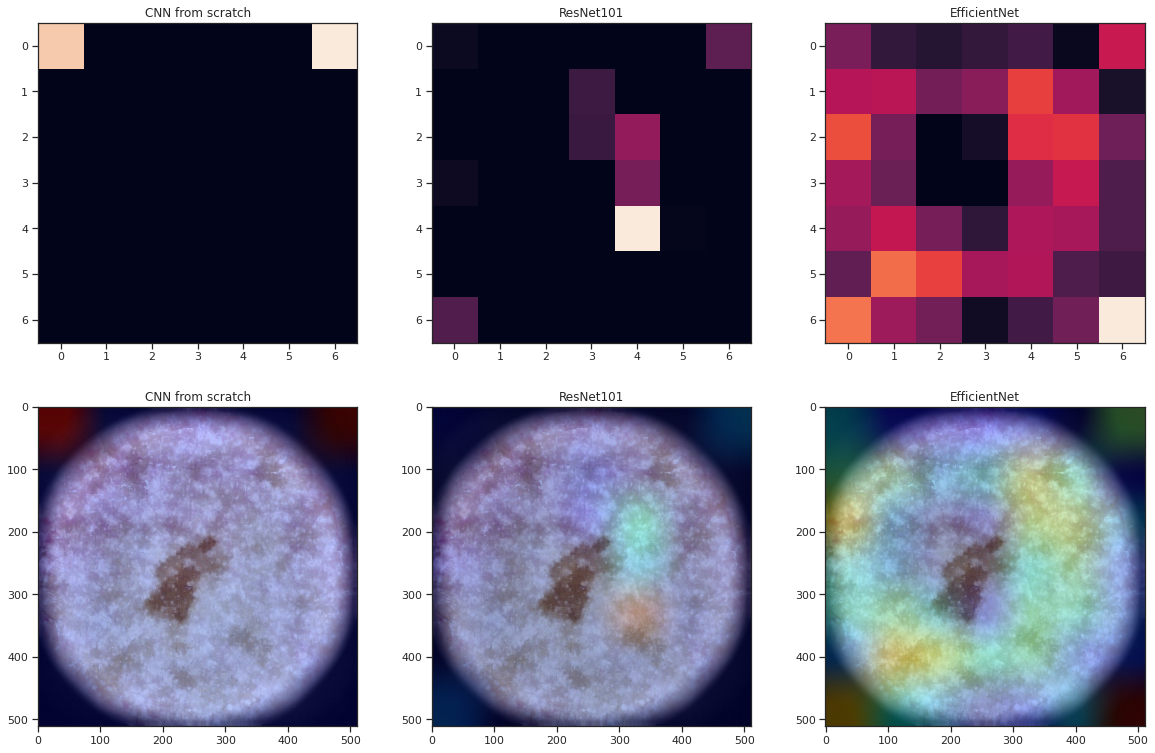

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## BCC

In [ ]:
img_path = '/content/split/test/BCC/ISIC_0026350.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.10367328
ResNet101:  0.05413837
EfficientNet:  0.014149106


CNN from scratch:  0.10367328
ResNet101:  0.05413837
EfficientNet:  0.014149106


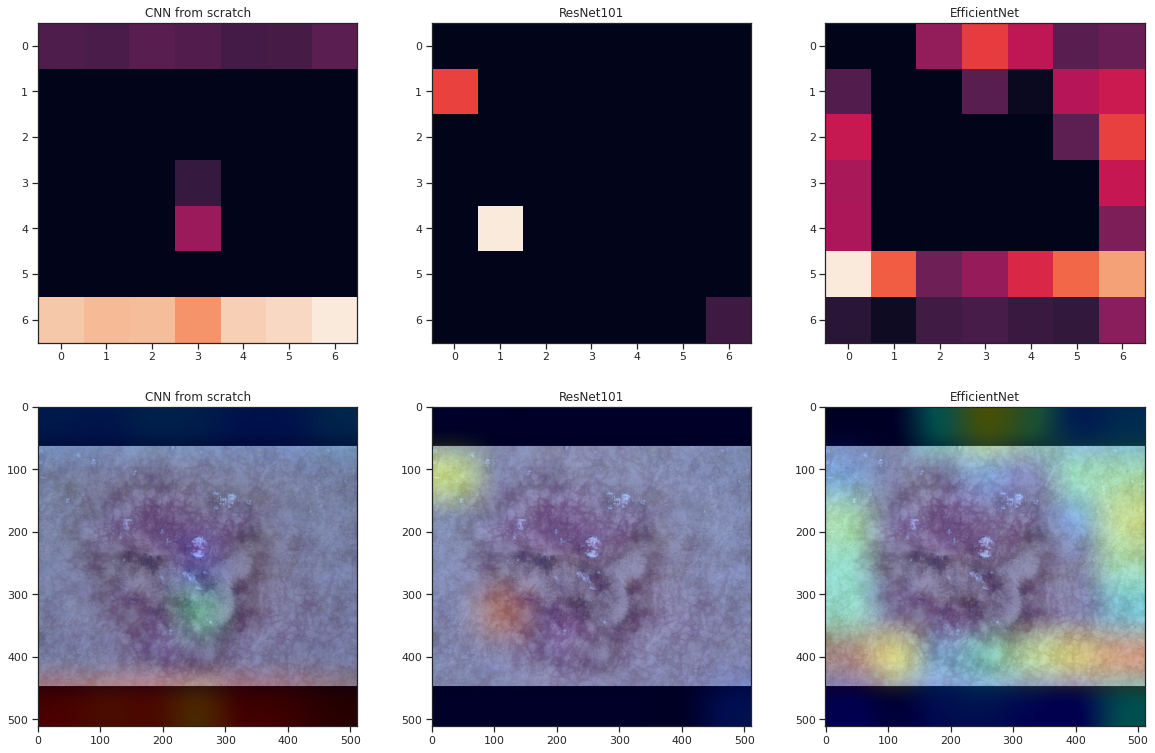

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## BKL

In [ ]:
img_path = '/content/split/test/BKL/ISIC_0072999.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.55642146
ResNet101:  0.28030765
EfficientNet:  0.82612157


CNN from scratch:  0.55642146
ResNet101:  0.28030765
EfficientNet:  0.82612157


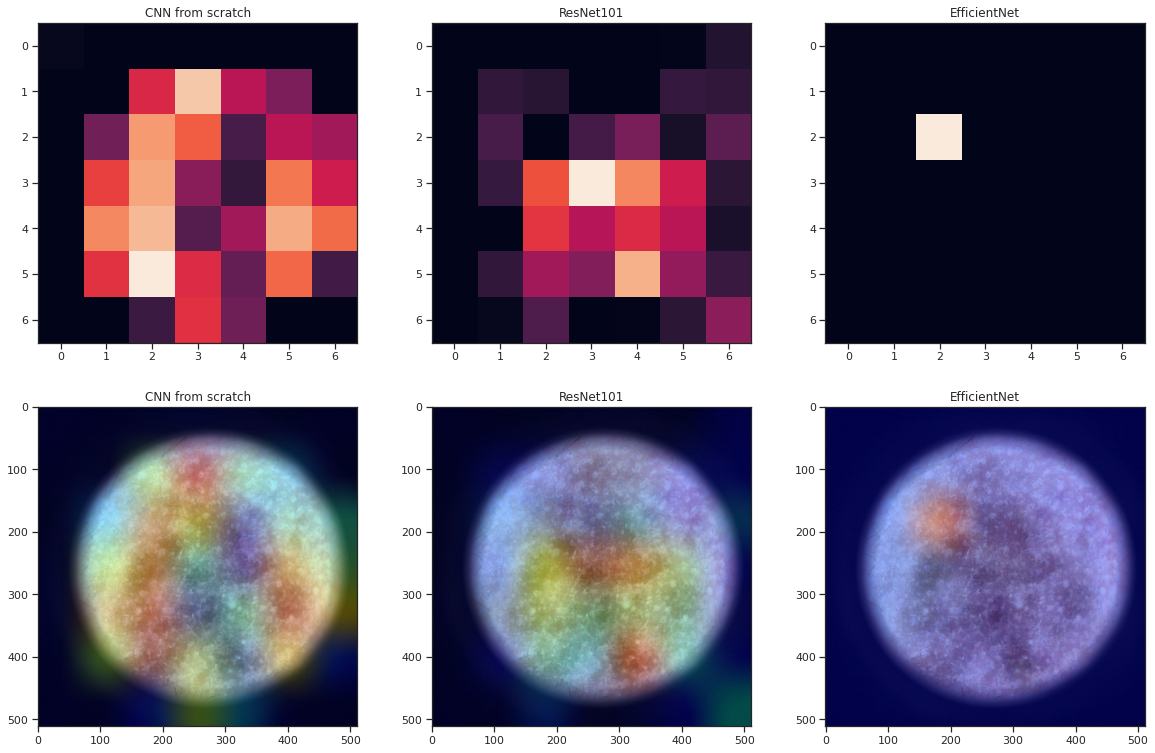

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## DF

In [ ]:
img_path = '/content/split/test/DF/ISIC_0033256.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.0020044965
ResNet101:  1.3668824e-05
EfficientNet:  0.0014904166


CNN from scratch:  0.0020044965
ResNet101:  1.3668824e-05
EfficientNet:  0.0014904166


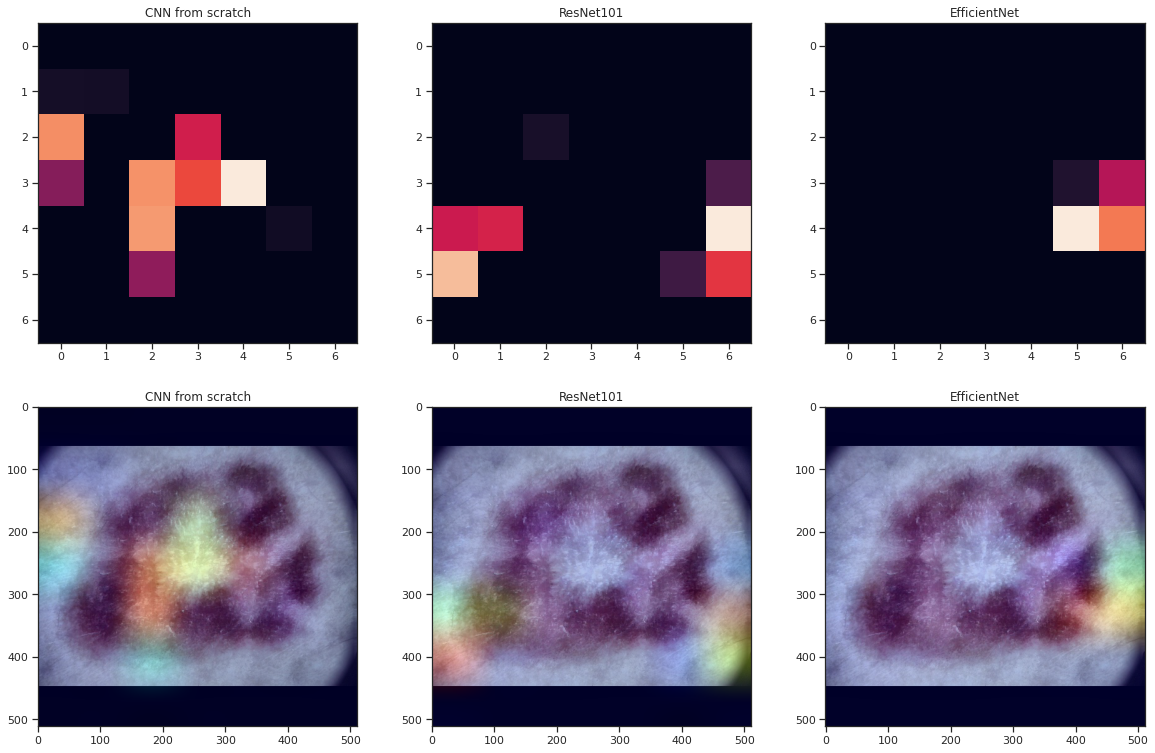

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## MEL

In [ ]:
img_path = '/content/split/test/MEL/ISIC_0064161.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  8.784191e-06
ResNet101:  3.884512e-07
EfficientNet:  2.3569723e-06


CNN from scratch:  8.784191e-06
ResNet101:  3.884512e-07
EfficientNet:  2.3569723e-06


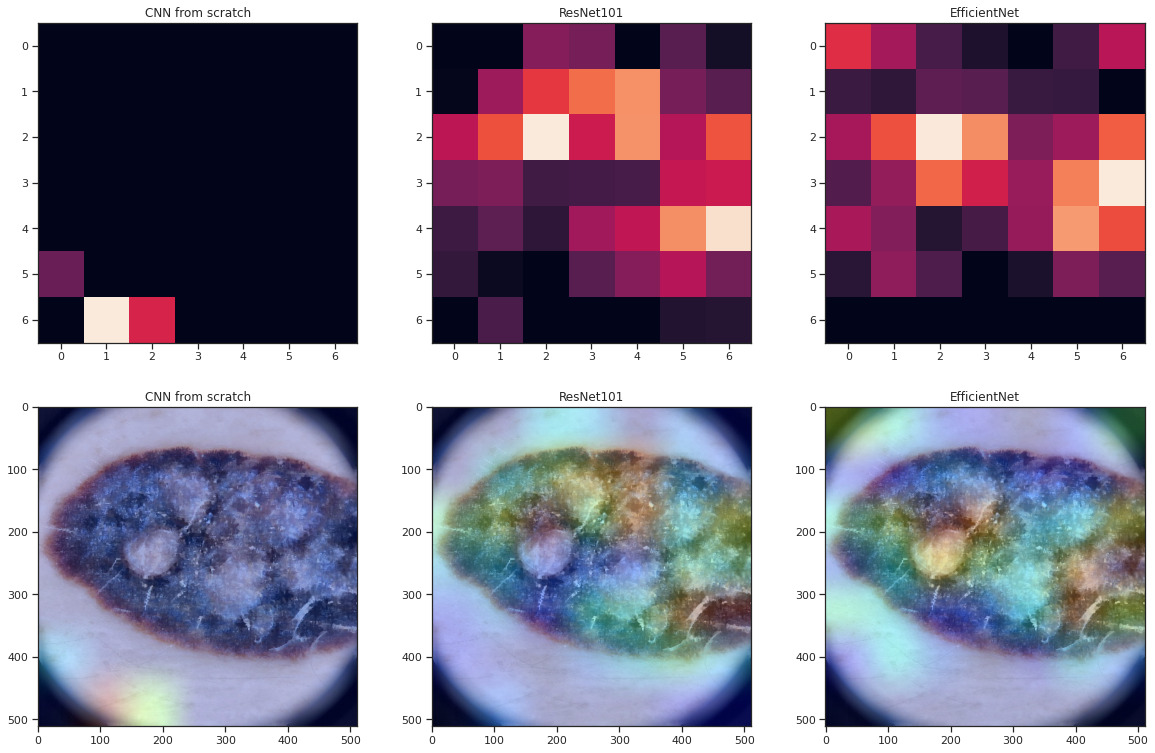

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## NV

In [ ]:
img_path = '/content/split/test/NV/ISIC_0033375.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.00017829494
ResNet101:  3.8764942e-06
EfficientNet:  0.00025585253


CNN from scratch:  0.00017829494
ResNet101:  3.8764942e-06
EfficientNet:  0.00025585253


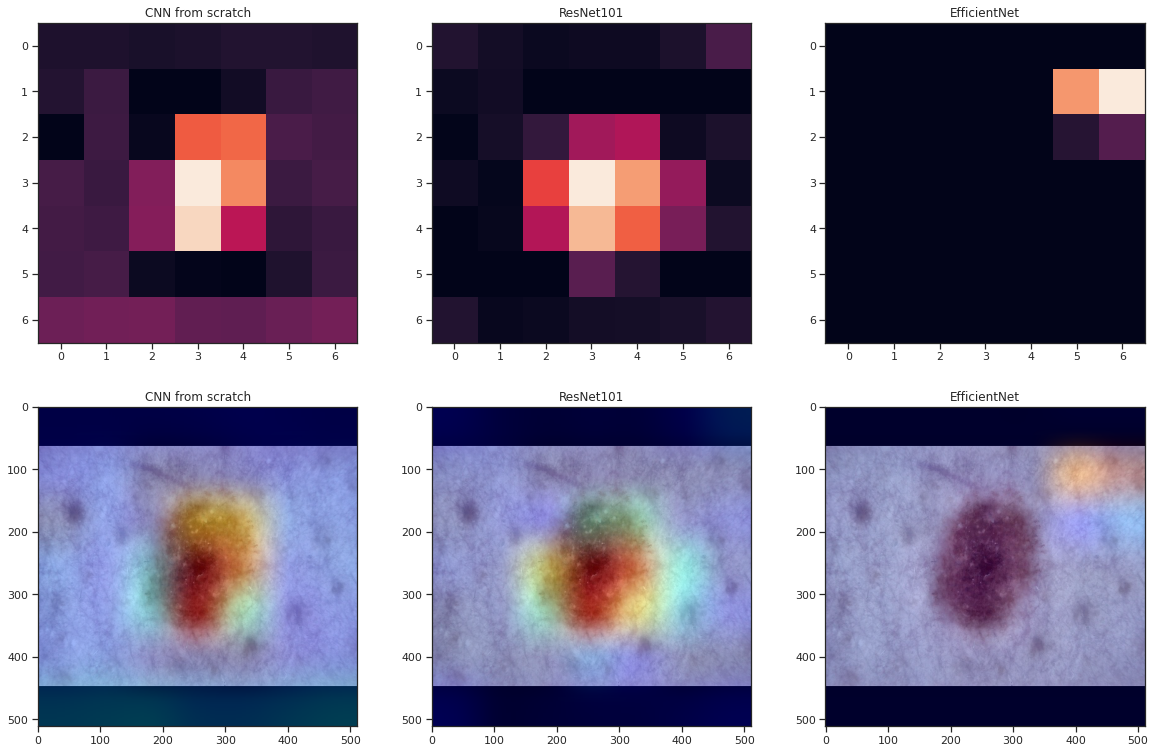

In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## SCC

In [ ]:
img_path = '/content/split/test/SCC/ISIC_0071905.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.05897839
ResNet101:  0.0069868714
EfficientNet:  0.042160872


In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)

## VASC

In [ ]:
img_path = '/content/split/test/VASC/ISIC_0054952.jpg'

In [ ]:
img = cv2.imread(img_path)
cv2_imshow(img)

In [ ]:
img_array = get_img_array(img_path, target_size=(300, 300))
scratch_predictions = cnn_scratch.predict(img_array)
heatmap_scratch = make_heatmap(img_array, cnn_scratch, get_last_conv_layer_index(cnn_scratch), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
resnet101_predictions = resnet101.predict(img_array)
heatmap_resnet101 = make_heatmap(img_array, resnet101, get_last_conv_layer_index(resnet101), 1)

img_array = get_img_array(img_path, target_size=(224, 224))
efficientnet_predictions = efficientnet.predict(img_array)
heatmap_efficientnet = make_heatmap(img_array, efficientnet, get_last_conv_layer_index(efficientnet), 1)

print("CNN from scratch: ", scratch_predictions[0][0])
print("ResNet101: ", resnet101_predictions[0][0])
print("EfficientNet: ", efficientnet_predictions[0][0])

CNN from scratch:  0.0081997095
ResNet101:  4.5971874e-06
EfficientNet:  0.00015540079


In [ ]:
heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam = calculate_heatmaps(img_path, cnn_scratch, resnet101, efficientnet)
print_heatmaps(heatmap_scratch, heatmap_resnet101, heatmap_efficientnet, scratch_gradcam, resnet101_gradcam, efficientnet_gradcam)